In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'diffusion_fa',
    'features_clin' : [],
    'balance_data'  : False,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
    'exclude'       : ['t1t2'],
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_e_e_e_1_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2918641, 918)
(2918641, 8)
validation
(345044, 918)
(345044, 8)
test
(360444, 918)
(360444, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 918)]             0         


 dense (Dense)               (None, 2048)              1882112   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4670344 (17.82 MB)


Trainable params: 4670344 (17.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/30 [>.............................] - ETA: 4:43 - loss: 2.5362 - STD: 0.1453 - MAE: 0.2195

 2/30 [=>............................] - ETA: 1:08 - loss: 2.4834 - STD: 0.1094 - MAE: 0.2182

 3/30 [==>...........................] - ETA: 38s - loss: 2.3048 - STD: 0.0912 - MAE: 0.2174 

 4/30 [===>..........................] - ETA: 28s - loss: 2.2295 - STD: 0.0801 - MAE: 0.2171

 5/30 [====>.........................] - ETA: 22s - loss: 2.1910 - STD: 0.0721 - MAE: 0.2170

 6/30 [=====>........................] - ETA: 19s - loss: 2.1697 - STD: 0.0664 - MAE: 0.2170

 7/30 [======>.......................] - ETA: 17s - loss: 2.1574 - STD: 0.0625 - MAE: 0.2170

 8/30 [=======>......................] - ETA: 15s - loss: 2.1494 - STD: 0.0596 - MAE: 0.2170

 9/30 [========>.....................] - ETA: 13s - loss: 2.1433 - STD: 0.0575 - MAE: 0.2170

10/30 [=========>....................] - ETA: 12s - loss: 2.1382 - STD: 0.0560 - MAE: 0.2170

11/30 [==========>...................] - ETA: 11s - loss: 2.1332 - STD: 0.0549 - MAE: 0.2170

12/30 [===========>..................] - ETA: 10s - loss: 2.1289 - STD: 0.0542 - MAE: 0.2169

13/30 [============>.................] - ETA: 9s - loss: 2.1248 - STD: 0.0535 - MAE: 0.2169 

14/30 [=============>................] - ETA: 9s - loss: 2.1208 - STD: 0.0530 - MAE: 0.2168

15/30 [==============>...............] - ETA: 8s - loss: 2.1168 - STD: 0.0523 - MAE: 0.2168

16/30 [===============>..............] - ETA: 7s - loss: 2.1133 - STD: 0.0516 - MAE: 0.2168

17/30 [================>.............] - ETA: 6s - loss: 2.1099 - STD: 0.0507 - MAE: 0.2167

18/30 [=================>............] - ETA: 6s - loss: 2.1066 - STD: 0.0498 - MAE: 0.2167

19/30 [==================>...........] - ETA: 5s - loss: 2.1038 - STD: 0.0488 - MAE: 0.2167

20/30 [===================>..........] - ETA: 5s - loss: 2.1012 - STD: 0.0479 - MAE: 0.2168

21/30 [====================>.........] - ETA: 4s - loss: 2.0990 - STD: 0.0470 - MAE: 0.2168

22/30 [=====================>........] - ETA: 4s - loss: 2.0970 - STD: 0.0462 - MAE: 0.2168

23/30 [======================>.......] - ETA: 3s - loss: 2.0953 - STD: 0.0455 - MAE: 0.2168

24/30 [=======================>......] - ETA: 2s - loss: 2.0938 - STD: 0.0450 - MAE: 0.2168

25/30 [========================>.....] - ETA: 2s - loss: 2.0924 - STD: 0.0445 - MAE: 0.2168

26/30 [=========================>....] - ETA: 1s - loss: 2.0911 - STD: 0.0441 - MAE: 0.2168

27/30 [==========================>...] - ETA: 1s - loss: 2.0899 - STD: 0.0437 - MAE: 0.2168

28/30 [===========================>..] - ETA: 0s - loss: 2.0886 - STD: 0.0433 - MAE: 0.2168

29/30 [============================>.] - ETA: 0s - loss: 2.0874 - STD: 0.0429 - MAE: 0.2168

30/30 [==============================] - ETA: 0s - loss: 2.0862 - STD: 0.0425 - MAE: 0.2168

30/30 [==============================] - 27s 585ms/step - loss: 2.0862 - STD: 0.0425 - MAE: 0.2168 - val_loss: 2.0530 - val_STD: 0.0313 - val_MAE: 0.2168


Epoch 2/10000


 1/30 [>.............................] - ETA: 15s - loss: 2.0527 - STD: 0.0313 - MAE: 0.2168

 2/30 [=>............................] - ETA: 11s - loss: 2.0525 - STD: 0.0313 - MAE: 0.2168

 3/30 [==>...........................] - ETA: 11s - loss: 2.0523 - STD: 0.0313 - MAE: 0.2168

 4/30 [===>..........................] - ETA: 10s - loss: 2.0524 - STD: 0.0315 - MAE: 0.2168

 5/30 [====>.........................] - ETA: 10s - loss: 2.0525 - STD: 0.0317 - MAE: 0.2168

 6/30 [=====>........................] - ETA: 9s - loss: 2.0524 - STD: 0.0320 - MAE: 0.2167 

 7/30 [======>.......................] - ETA: 9s - loss: 2.0524 - STD: 0.0322 - MAE: 0.2167

 8/30 [=======>......................] - ETA: 8s - loss: 2.0525 - STD: 0.0325 - MAE: 0.2167

 9/30 [========>.....................] - ETA: 8s - loss: 2.0527 - STD: 0.0328 - MAE: 0.2167

10/30 [=========>....................] - ETA: 8s - loss: 2.0529 - STD: 0.0329 - MAE: 0.2167

11/30 [==========>...................] - ETA: 7s - loss: 2.0529 - STD: 0.0330 - MAE: 0.2167

12/30 [===========>..................] - ETA: 7s - loss: 2.0528 - STD: 0.0330 - MAE: 0.2167

13/30 [============>.................] - ETA: 6s - loss: 2.0528 - STD: 0.0329 - MAE: 0.2167

14/30 [=============>................] - ETA: 6s - loss: 2.0528 - STD: 0.0327 - MAE: 0.2167

15/30 [==============>...............] - ETA: 6s - loss: 2.0527 - STD: 0.0326 - MAE: 0.2167

16/30 [===============>..............] - ETA: 5s - loss: 2.0526 - STD: 0.0325 - MAE: 0.2167

17/30 [================>.............] - ETA: 5s - loss: 2.0526 - STD: 0.0324 - MAE: 0.2167

18/30 [=================>............] - ETA: 4s - loss: 2.0525 - STD: 0.0323 - MAE: 0.2167

19/30 [==================>...........] - ETA: 4s - loss: 2.0525 - STD: 0.0323 - MAE: 0.2167

20/30 [===================>..........] - ETA: 4s - loss: 2.0524 - STD: 0.0323 - MAE: 0.2167

21/30 [====================>.........] - ETA: 3s - loss: 2.0524 - STD: 0.0323 - MAE: 0.2167

22/30 [=====================>........] - ETA: 3s - loss: 2.0523 - STD: 0.0323 - MAE: 0.2167

23/30 [======================>.......] - ETA: 2s - loss: 2.0524 - STD: 0.0323 - MAE: 0.2167

24/30 [=======================>......] - ETA: 2s - loss: 2.0524 - STD: 0.0323 - MAE: 0.2167

25/30 [========================>.....] - ETA: 2s - loss: 2.0523 - STD: 0.0322 - MAE: 0.2167

26/30 [=========================>....] - ETA: 1s - loss: 2.0523 - STD: 0.0322 - MAE: 0.2167

27/30 [==========================>...] - ETA: 1s - loss: 2.0523 - STD: 0.0321 - MAE: 0.2167

28/30 [===========================>..] - ETA: 0s - loss: 2.0523 - STD: 0.0321 - MAE: 0.2167

29/30 [============================>.] - ETA: 0s - loss: 2.0522 - STD: 0.0321 - MAE: 0.2167

30/30 [==============================] - ETA: 0s - loss: 2.0522 - STD: 0.0321 - MAE: 0.2167

30/30 [==============================] - 13s 430ms/step - loss: 2.0522 - STD: 0.0321 - MAE: 0.2167 - val_loss: 2.0525 - val_STD: 0.0322 - val_MAE: 0.2167


Epoch 3/10000


 1/30 [>.............................] - ETA: 16s - loss: 2.0516 - STD: 0.0322 - MAE: 0.2167

 2/30 [=>............................] - ETA: 11s - loss: 2.0517 - STD: 0.0323 - MAE: 0.2167

 3/30 [==>...........................] - ETA: 11s - loss: 2.0515 - STD: 0.0323 - MAE: 0.2167

 4/30 [===>..........................] - ETA: 10s - loss: 2.0512 - STD: 0.0322 - MAE: 0.2167

 5/30 [====>.........................] - ETA: 10s - loss: 2.0515 - STD: 0.0322 - MAE: 0.2167

 6/30 [=====>........................] - ETA: 9s - loss: 2.0515 - STD: 0.0322 - MAE: 0.2167 

 7/30 [======>.......................] - ETA: 9s - loss: 2.0515 - STD: 0.0321 - MAE: 0.2167

 8/30 [=======>......................] - ETA: 9s - loss: 2.0513 - STD: 0.0320 - MAE: 0.2167

 9/30 [========>.....................] - ETA: 8s - loss: 2.0512 - STD: 0.0320 - MAE: 0.2167

10/30 [=========>....................] - ETA: 8s - loss: 2.0513 - STD: 0.0320 - MAE: 0.2167

11/30 [==========>...................] - ETA: 7s - loss: 2.0512 - STD: 0.0320 - MAE: 0.2167

12/30 [===========>..................] - ETA: 7s - loss: 2.0512 - STD: 0.0320 - MAE: 0.2167

13/30 [============>.................] - ETA: 6s - loss: 2.0511 - STD: 0.0320 - MAE: 0.2167

14/30 [=============>................] - ETA: 6s - loss: 2.0511 - STD: 0.0320 - MAE: 0.2167

15/30 [==============>...............] - ETA: 6s - loss: 2.0510 - STD: 0.0320 - MAE: 0.2167

16/30 [===============>..............] - ETA: 5s - loss: 2.0509 - STD: 0.0319 - MAE: 0.2167

17/30 [================>.............] - ETA: 5s - loss: 2.0509 - STD: 0.0319 - MAE: 0.2167

18/30 [=================>............] - ETA: 4s - loss: 2.0508 - STD: 0.0318 - MAE: 0.2167

19/30 [==================>...........] - ETA: 4s - loss: 2.0507 - STD: 0.0318 - MAE: 0.2167

20/30 [===================>..........] - ETA: 4s - loss: 2.0506 - STD: 0.0318 - MAE: 0.2167

21/30 [====================>.........] - ETA: 3s - loss: 2.0505 - STD: 0.0318 - MAE: 0.2167

22/30 [=====================>........] - ETA: 3s - loss: 2.0504 - STD: 0.0318 - MAE: 0.2167

23/30 [======================>.......] - ETA: 2s - loss: 2.0502 - STD: 0.0318 - MAE: 0.2167

24/30 [=======================>......] - ETA: 2s - loss: 2.0501 - STD: 0.0318 - MAE: 0.2167

25/30 [========================>.....] - ETA: 2s - loss: 2.0498 - STD: 0.0318 - MAE: 0.2167

26/30 [=========================>....] - ETA: 1s - loss: 2.0495 - STD: 0.0318 - MAE: 0.2166

27/30 [==========================>...] - ETA: 1s - loss: 2.0493 - STD: 0.0318 - MAE: 0.2166

28/30 [===========================>..] - ETA: 0s - loss: 2.0493 - STD: 0.0318 - MAE: 0.2166

29/30 [============================>.] - ETA: 0s - loss: 2.0490 - STD: 0.0318 - MAE: 0.2166

30/30 [==============================] - ETA: 0s - loss: 2.0487 - STD: 0.0318 - MAE: 0.2166

30/30 [==============================] - 13s 431ms/step - loss: 2.0487 - STD: 0.0318 - MAE: 0.2166 - val_loss: 2.0358 - val_STD: 0.0315 - val_MAE: 0.2161


Epoch 4/10000


 1/30 [>.............................] - ETA: 15s - loss: 2.0359 - STD: 0.0310 - MAE: 0.2161

 2/30 [=>............................] - ETA: 2s - loss: 2.0361 - STD: 0.0316 - MAE: 0.2161 

 3/30 [==>...........................] - ETA: 6s - loss: 2.0343 - STD: 0.0317 - MAE: 0.2161

 4/30 [===>..........................] - ETA: 7s - loss: 2.0329 - STD: 0.0317 - MAE: 0.2160

 5/30 [====>.........................] - ETA: 8s - loss: 2.0311 - STD: 0.0317 - MAE: 0.2159

 6/30 [=====>........................] - ETA: 8s - loss: 2.0292 - STD: 0.0320 - MAE: 0.2158

 7/30 [======>.......................] - ETA: 8s - loss: 2.0274 - STD: 0.0324 - MAE: 0.2158

 8/30 [=======>......................] - ETA: 7s - loss: 2.0250 - STD: 0.0327 - MAE: 0.2156

 9/30 [========>.....................] - ETA: 7s - loss: 2.0228 - STD: 0.0332 - MAE: 0.2155

10/30 [=========>....................] - ETA: 7s - loss: 2.0204 - STD: 0.0337 - MAE: 0.2154

11/30 [==========>...................] - ETA: 7s - loss: 2.0180 - STD: 0.0343 - MAE: 0.2153

12/30 [===========>..................] - ETA: 6s - loss: 2.0153 - STD: 0.0348 - MAE: 0.2151

13/30 [============>.................] - ETA: 6s - loss: 2.0124 - STD: 0.0355 - MAE: 0.2150

14/30 [=============>................] - ETA: 6s - loss: 2.0092 - STD: 0.0360 - MAE: 0.2148

15/30 [==============>...............] - ETA: 5s - loss: 2.0057 - STD: 0.0366 - MAE: 0.2147

16/30 [===============>..............] - ETA: 5s - loss: 2.0020 - STD: 0.0374 - MAE: 0.2145

17/30 [================>.............] - ETA: 5s - loss: 1.9983 - STD: 0.0380 - MAE: 0.2143

18/30 [=================>............] - ETA: 4s - loss: 1.9947 - STD: 0.0393 - MAE: 0.2141

19/30 [==================>...........] - ETA: 4s - loss: 1.9907 - STD: 0.0399 - MAE: 0.2139

20/30 [===================>..........] - ETA: 3s - loss: 1.9863 - STD: 0.0408 - MAE: 0.2137

21/30 [====================>.........] - ETA: 3s - loss: 1.9823 - STD: 0.0422 - MAE: 0.2134

22/30 [=====================>........] - ETA: 3s - loss: 1.9777 - STD: 0.0430 - MAE: 0.2132

23/30 [======================>.......] - ETA: 2s - loss: 1.9730 - STD: 0.0438 - MAE: 0.2130

24/30 [=======================>......] - ETA: 2s - loss: 1.9686 - STD: 0.0450 - MAE: 0.2127

25/30 [========================>.....] - ETA: 1s - loss: 1.9637 - STD: 0.0458 - MAE: 0.2124

26/30 [=========================>....] - ETA: 1s - loss: 1.9589 - STD: 0.0466 - MAE: 0.2122

27/30 [==========================>...] - ETA: 1s - loss: 1.9543 - STD: 0.0478 - MAE: 0.2119

28/30 [===========================>..] - ETA: 0s - loss: 1.9495 - STD: 0.0487 - MAE: 0.2117

29/30 [============================>.] - ETA: 0s - loss: 1.9445 - STD: 0.0496 - MAE: 0.2114

30/30 [==============================] - ETA: 0s - loss: 1.9399 - STD: 0.0508 - MAE: 0.2112

30/30 [==============================] - 13s 432ms/step - loss: 1.9399 - STD: 0.0508 - MAE: 0.2112 - val_loss: 1.8104 - val_STD: 0.0745 - val_MAE: 0.2043


Epoch 5/10000


 1/30 [>.............................] - ETA: 17s - loss: 1.8029 - STD: 0.0748 - MAE: 0.2041

 2/30 [=>............................] - ETA: 11s - loss: 1.7932 - STD: 0.0790 - MAE: 0.2033

 3/30 [==>...........................] - ETA: 11s - loss: 1.7869 - STD: 0.0806 - MAE: 0.2029

 4/30 [===>..........................] - ETA: 7s - loss: 1.7862 - STD: 0.0803 - MAE: 0.2029 

 5/30 [====>.........................] - ETA: 8s - loss: 1.7830 - STD: 0.0822 - MAE: 0.2026

 6/30 [=====>........................] - ETA: 8s - loss: 1.7768 - STD: 0.0825 - MAE: 0.2024

 7/30 [======>.......................] - ETA: 8s - loss: 1.7710 - STD: 0.0830 - MAE: 0.2022

 8/30 [=======>......................] - ETA: 8s - loss: 1.7682 - STD: 0.0841 - MAE: 0.2019

 9/30 [========>.....................] - ETA: 7s - loss: 1.7655 - STD: 0.0842 - MAE: 0.2019

10/30 [=========>....................] - ETA: 7s - loss: 1.7619 - STD: 0.0849 - MAE: 0.2017

11/30 [==========>...................] - ETA: 7s - loss: 1.7577 - STD: 0.0855 - MAE: 0.2015

12/30 [===========>..................] - ETA: 6s - loss: 1.7550 - STD: 0.0856 - MAE: 0.2014

13/30 [============>.................] - ETA: 6s - loss: 1.7529 - STD: 0.0864 - MAE: 0.2012

14/30 [=============>................] - ETA: 6s - loss: 1.7500 - STD: 0.0867 - MAE: 0.2011

15/30 [==============>...............] - ETA: 5s - loss: 1.7465 - STD: 0.0871 - MAE: 0.2009

16/30 [===============>..............] - ETA: 5s - loss: 1.7438 - STD: 0.0877 - MAE: 0.2008

17/30 [================>.............] - ETA: 5s - loss: 1.7415 - STD: 0.0879 - MAE: 0.2007

18/30 [=================>............] - ETA: 4s - loss: 1.7389 - STD: 0.0884 - MAE: 0.2005

19/30 [==================>...........] - ETA: 4s - loss: 1.7361 - STD: 0.0887 - MAE: 0.2004

20/30 [===================>..........] - ETA: 3s - loss: 1.7338 - STD: 0.0889 - MAE: 0.2003

21/30 [====================>.........] - ETA: 3s - loss: 1.7317 - STD: 0.0895 - MAE: 0.2001

22/30 [=====================>........] - ETA: 3s - loss: 1.7297 - STD: 0.0897 - MAE: 0.2000

23/30 [======================>.......] - ETA: 2s - loss: 1.7273 - STD: 0.0902 - MAE: 0.1999

24/30 [=======================>......] - ETA: 2s - loss: 1.7250 - STD: 0.0905 - MAE: 0.1998

25/30 [========================>.....] - ETA: 1s - loss: 1.7231 - STD: 0.0908 - MAE: 0.1997

26/30 [=========================>....] - ETA: 1s - loss: 1.7212 - STD: 0.0913 - MAE: 0.1995

27/30 [==========================>...] - ETA: 1s - loss: 1.7192 - STD: 0.0916 - MAE: 0.1994

28/30 [===========================>..] - ETA: 0s - loss: 1.7170 - STD: 0.0919 - MAE: 0.1993

29/30 [============================>.] - ETA: 0s - loss: 1.7151 - STD: 0.0923 - MAE: 0.1992

30/30 [==============================] - ETA: 0s - loss: 1.7134 - STD: 0.0926 - MAE: 0.1991

30/30 [==============================] - 13s 434ms/step - loss: 1.7134 - STD: 0.0926 - MAE: 0.1991 - val_loss: 1.7465 - val_STD: 0.1089 - val_MAE: 0.1970


Epoch 6/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.6654 - STD: 0.1074 - MAE: 0.1949

 2/30 [=>............................] - ETA: 11s - loss: 1.6638 - STD: 0.1041 - MAE: 0.1955

 3/30 [==>...........................] - ETA: 11s - loss: 1.6611 - STD: 0.1047 - MAE: 0.1953

 4/30 [===>..........................] - ETA: 10s - loss: 1.6583 - STD: 0.1048 - MAE: 0.1952

 5/30 [====>.........................] - ETA: 10s - loss: 1.6568 - STD: 0.1045 - MAE: 0.1952

 6/30 [=====>........................] - ETA: 9s - loss: 1.6560 - STD: 0.1052 - MAE: 0.1950 

 7/30 [======>.......................] - ETA: 9s - loss: 1.6560 - STD: 0.1049 - MAE: 0.1951

 8/30 [=======>......................] - ETA: 9s - loss: 1.6547 - STD: 0.1055 - MAE: 0.1949

 9/30 [========>.....................] - ETA: 8s - loss: 1.6531 - STD: 0.1055 - MAE: 0.1949

10/30 [=========>....................] - ETA: 8s - loss: 1.6519 - STD: 0.1055 - MAE: 0.1948

11/30 [==========>...................] - ETA: 7s - loss: 1.6518 - STD: 0.1060 - MAE: 0.1947

12/30 [===========>..................] - ETA: 6s - loss: 1.6513 - STD: 0.1059 - MAE: 0.1947

13/30 [============>.................] - ETA: 6s - loss: 1.6507 - STD: 0.1063 - MAE: 0.1946

14/30 [=============>................] - ETA: 6s - loss: 1.6491 - STD: 0.1064 - MAE: 0.1945

15/30 [==============>...............] - ETA: 5s - loss: 1.6477 - STD: 0.1066 - MAE: 0.1945

16/30 [===============>..............] - ETA: 5s - loss: 1.6461 - STD: 0.1068 - MAE: 0.1944

17/30 [================>.............] - ETA: 5s - loss: 1.6448 - STD: 0.1068 - MAE: 0.1943

18/30 [=================>............] - ETA: 4s - loss: 1.6435 - STD: 0.1070 - MAE: 0.1942

19/30 [==================>...........] - ETA: 4s - loss: 1.6421 - STD: 0.1072 - MAE: 0.1942

20/30 [===================>..........] - ETA: 3s - loss: 1.6408 - STD: 0.1073 - MAE: 0.1941

21/30 [====================>.........] - ETA: 3s - loss: 1.6393 - STD: 0.1075 - MAE: 0.1940

22/30 [=====================>........] - ETA: 3s - loss: 1.6382 - STD: 0.1076 - MAE: 0.1939

23/30 [======================>.......] - ETA: 2s - loss: 1.6369 - STD: 0.1079 - MAE: 0.1938

24/30 [=======================>......] - ETA: 2s - loss: 1.6361 - STD: 0.1080 - MAE: 0.1938

25/30 [========================>.....] - ETA: 1s - loss: 1.6353 - STD: 0.1082 - MAE: 0.1937

26/30 [=========================>....] - ETA: 1s - loss: 1.6347 - STD: 0.1082 - MAE: 0.1937

27/30 [==========================>...] - ETA: 1s - loss: 1.6339 - STD: 0.1085 - MAE: 0.1936

28/30 [===========================>..] - ETA: 0s - loss: 1.6328 - STD: 0.1086 - MAE: 0.1935

29/30 [============================>.] - ETA: 0s - loss: 1.6315 - STD: 0.1088 - MAE: 0.1935

30/30 [==============================] - ETA: 0s - loss: 1.6305 - STD: 0.1090 - MAE: 0.1934

30/30 [==============================] - 13s 431ms/step - loss: 1.6305 - STD: 0.1090 - MAE: 0.1934 - val_loss: 1.6612 - val_STD: 0.1141 - val_MAE: 0.1931


Epoch 7/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.6078 - STD: 0.1101 - MAE: 0.1923

 2/30 [=>............................] - ETA: 11s - loss: 1.6068 - STD: 0.1137 - MAE: 0.1915

 3/30 [==>...........................] - ETA: 11s - loss: 1.6035 - STD: 0.1133 - MAE: 0.1915

 4/30 [===>..........................] - ETA: 10s - loss: 1.5998 - STD: 0.1139 - MAE: 0.1912

 5/30 [====>.........................] - ETA: 10s - loss: 1.5975 - STD: 0.1142 - MAE: 0.1911

 6/30 [=====>........................] - ETA: 9s - loss: 1.5961 - STD: 0.1140 - MAE: 0.1911 

 7/30 [======>.......................] - ETA: 9s - loss: 1.5953 - STD: 0.1145 - MAE: 0.1909

 8/30 [=======>......................] - ETA: 9s - loss: 1.5944 - STD: 0.1144 - MAE: 0.1909

 9/30 [========>.....................] - ETA: 8s - loss: 1.5931 - STD: 0.1146 - MAE: 0.1908

10/30 [=========>....................] - ETA: 8s - loss: 1.5921 - STD: 0.1146 - MAE: 0.1908

11/30 [==========>...................] - ETA: 7s - loss: 1.5919 - STD: 0.1147 - MAE: 0.1907

12/30 [===========>..................] - ETA: 6s - loss: 1.5904 - STD: 0.1150 - MAE: 0.1906

13/30 [============>.................] - ETA: 6s - loss: 1.5898 - STD: 0.1150 - MAE: 0.1906

14/30 [=============>................] - ETA: 6s - loss: 1.5901 - STD: 0.1153 - MAE: 0.1905

15/30 [==============>...............] - ETA: 5s - loss: 1.5902 - STD: 0.1152 - MAE: 0.1905

16/30 [===============>..............] - ETA: 5s - loss: 1.5895 - STD: 0.1154 - MAE: 0.1905

17/30 [================>.............] - ETA: 5s - loss: 1.5880 - STD: 0.1155 - MAE: 0.1904

18/30 [=================>............] - ETA: 4s - loss: 1.5865 - STD: 0.1156 - MAE: 0.1903

19/30 [==================>...........] - ETA: 4s - loss: 1.5858 - STD: 0.1158 - MAE: 0.1903

20/30 [===================>..........] - ETA: 3s - loss: 1.5848 - STD: 0.1158 - MAE: 0.1902

21/30 [====================>.........] - ETA: 3s - loss: 1.5835 - STD: 0.1159 - MAE: 0.1902

22/30 [=====================>........] - ETA: 3s - loss: 1.5823 - STD: 0.1161 - MAE: 0.1901

23/30 [======================>.......] - ETA: 2s - loss: 1.5814 - STD: 0.1161 - MAE: 0.1900

24/30 [=======================>......] - ETA: 2s - loss: 1.5808 - STD: 0.1163 - MAE: 0.1900

25/30 [========================>.....] - ETA: 1s - loss: 1.5801 - STD: 0.1163 - MAE: 0.1899

26/30 [=========================>....] - ETA: 1s - loss: 1.5788 - STD: 0.1164 - MAE: 0.1899

27/30 [==========================>...] - ETA: 1s - loss: 1.5775 - STD: 0.1166 - MAE: 0.1898

28/30 [===========================>..] - ETA: 0s - loss: 1.5766 - STD: 0.1167 - MAE: 0.1897

29/30 [============================>.] - ETA: 0s - loss: 1.5760 - STD: 0.1168 - MAE: 0.1897

30/30 [==============================] - ETA: 0s - loss: 1.5752 - STD: 0.1168 - MAE: 0.1896

30/30 [==============================] - 13s 430ms/step - loss: 1.5752 - STD: 0.1168 - MAE: 0.1896 - val_loss: 1.7153 - val_STD: 0.1287 - val_MAE: 0.1896


Epoch 8/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.5463 - STD: 0.1218 - MAE: 0.1872

 2/30 [=>............................] - ETA: 11s - loss: 1.5400 - STD: 0.1213 - MAE: 0.1871

 3/30 [==>...........................] - ETA: 11s - loss: 1.5362 - STD: 0.1209 - MAE: 0.1871

 4/30 [===>..........................] - ETA: 10s - loss: 1.5331 - STD: 0.1210 - MAE: 0.1870

 5/30 [====>.........................] - ETA: 10s - loss: 1.5312 - STD: 0.1209 - MAE: 0.1869

 6/30 [=====>........................] - ETA: 9s - loss: 1.5296 - STD: 0.1210 - MAE: 0.1868 

 7/30 [======>.......................] - ETA: 9s - loss: 1.5285 - STD: 0.1207 - MAE: 0.1868

 8/30 [=======>......................] - ETA: 9s - loss: 1.5274 - STD: 0.1209 - MAE: 0.1867

 9/30 [========>.....................] - ETA: 8s - loss: 1.5272 - STD: 0.1210 - MAE: 0.1867

10/30 [=========>....................] - ETA: 8s - loss: 1.5278 - STD: 0.1211 - MAE: 0.1866

11/30 [==========>...................] - ETA: 7s - loss: 1.5284 - STD: 0.1211 - MAE: 0.1866

12/30 [===========>..................] - ETA: 7s - loss: 1.5261 - STD: 0.1213 - MAE: 0.1864

13/30 [============>.................] - ETA: 6s - loss: 1.5223 - STD: 0.1216 - MAE: 0.1862

14/30 [=============>................] - ETA: 6s - loss: 1.5198 - STD: 0.1219 - MAE: 0.1860

15/30 [==============>...............] - ETA: 6s - loss: 1.5175 - STD: 0.1221 - MAE: 0.1858

16/30 [===============>..............] - ETA: 5s - loss: 1.5138 - STD: 0.1223 - MAE: 0.1856

17/30 [================>.............] - ETA: 5s - loss: 1.5097 - STD: 0.1225 - MAE: 0.1854

18/30 [=================>............] - ETA: 4s - loss: 1.5066 - STD: 0.1228 - MAE: 0.1852

19/30 [==================>...........] - ETA: 4s - loss: 1.5033 - STD: 0.1231 - MAE: 0.1850

20/30 [===================>..........] - ETA: 4s - loss: 1.4990 - STD: 0.1234 - MAE: 0.1847

21/30 [====================>.........] - ETA: 3s - loss: 1.4945 - STD: 0.1238 - MAE: 0.1844

22/30 [=====================>........] - ETA: 3s - loss: 1.4903 - STD: 0.1242 - MAE: 0.1841

23/30 [======================>.......] - ETA: 2s - loss: 1.4871 - STD: 0.1247 - MAE: 0.1838

24/30 [=======================>......] - ETA: 2s - loss: 1.4837 - STD: 0.1253 - MAE: 0.1835

25/30 [========================>.....] - ETA: 2s - loss: 1.4795 - STD: 0.1258 - MAE: 0.1832

26/30 [=========================>....] - ETA: 1s - loss: 1.4752 - STD: 0.1263 - MAE: 0.1828

27/30 [==========================>...] - ETA: 1s - loss: 1.4713 - STD: 0.1269 - MAE: 0.1825

28/30 [===========================>..] - ETA: 0s - loss: 1.4674 - STD: 0.1275 - MAE: 0.1822

29/30 [============================>.] - ETA: 0s - loss: 1.4634 - STD: 0.1280 - MAE: 0.1819

30/30 [==============================] - ETA: 0s - loss: 1.4627 - STD: 0.1286 - MAE: 0.1815

30/30 [==============================] - 13s 435ms/step - loss: 1.4627 - STD: 0.1286 - MAE: 0.1815 - val_loss: 1.5520 - val_STD: 0.1544 - val_MAE: 0.1781


Epoch 9/10000


 1/30 [>.............................] - ETA: 17s - loss: 1.3398 - STD: 0.1491 - MAE: 0.1704

 2/30 [=>............................] - ETA: 11s - loss: 1.3376 - STD: 0.1471 - MAE: 0.1709

 3/30 [==>...........................] - ETA: 11s - loss: 1.3306 - STD: 0.1478 - MAE: 0.1703

 4/30 [===>..........................] - ETA: 10s - loss: 1.3293 - STD: 0.1489 - MAE: 0.1701

 5/30 [====>.........................] - ETA: 10s - loss: 1.3263 - STD: 0.1490 - MAE: 0.1699

 6/30 [=====>........................] - ETA: 9s - loss: 1.3225 - STD: 0.1492 - MAE: 0.1696 

 7/30 [======>.......................] - ETA: 9s - loss: 1.3211 - STD: 0.1499 - MAE: 0.1694

 8/30 [=======>......................] - ETA: 9s - loss: 1.3183 - STD: 0.1502 - MAE: 0.1691

 9/30 [========>.....................] - ETA: 8s - loss: 1.3165 - STD: 0.1503 - MAE: 0.1690

10/30 [=========>....................] - ETA: 8s - loss: 1.3143 - STD: 0.1507 - MAE: 0.1688

11/30 [==========>...................] - ETA: 7s - loss: 1.3115 - STD: 0.1510 - MAE: 0.1686

12/30 [===========>..................] - ETA: 7s - loss: 1.3094 - STD: 0.1512 - MAE: 0.1684

13/30 [============>.................] - ETA: 6s - loss: 1.3073 - STD: 0.1516 - MAE: 0.1682

14/30 [=============>................] - ETA: 6s - loss: 1.3053 - STD: 0.1520 - MAE: 0.1680

15/30 [==============>...............] - ETA: 6s - loss: 1.3038 - STD: 0.1522 - MAE: 0.1678

16/30 [===============>..............] - ETA: 5s - loss: 1.3030 - STD: 0.1527 - MAE: 0.1676

17/30 [================>.............] - ETA: 5s - loss: 1.3034 - STD: 0.1530 - MAE: 0.1676

18/30 [=================>............] - ETA: 4s - loss: 1.3118 - STD: 0.1536 - MAE: 0.1677

19/30 [==================>...........] - ETA: 4s - loss: 1.3149 - STD: 0.1538 - MAE: 0.1678

20/30 [===================>..........] - ETA: 3s - loss: 1.3126 - STD: 0.1542 - MAE: 0.1676

21/30 [====================>.........] - ETA: 3s - loss: 1.3138 - STD: 0.1547 - MAE: 0.1674

22/30 [=====================>........] - ETA: 3s - loss: 1.3143 - STD: 0.1548 - MAE: 0.1674

23/30 [======================>.......] - ETA: 2s - loss: 1.3127 - STD: 0.1550 - MAE: 0.1673

24/30 [=======================>......] - ETA: 2s - loss: 1.3137 - STD: 0.1554 - MAE: 0.1672

25/30 [========================>.....] - ETA: 1s - loss: 1.3115 - STD: 0.1556 - MAE: 0.1670

26/30 [=========================>....] - ETA: 1s - loss: 1.3112 - STD: 0.1558 - MAE: 0.1669

27/30 [==========================>...] - ETA: 1s - loss: 1.3096 - STD: 0.1560 - MAE: 0.1668

28/30 [===========================>..] - ETA: 0s - loss: 1.3087 - STD: 0.1564 - MAE: 0.1666

29/30 [============================>.] - ETA: 0s - loss: 1.3076 - STD: 0.1566 - MAE: 0.1665

30/30 [==============================] - ETA: 0s - loss: 1.3060 - STD: 0.1567 - MAE: 0.1663

30/30 [==============================] - 13s 432ms/step - loss: 1.3060 - STD: 0.1567 - MAE: 0.1663 - val_loss: 1.4711 - val_STD: 0.1702 - val_MAE: 0.1683


Epoch 10/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.2729 - STD: 0.1631 - MAE: 0.1625

 2/30 [=>............................] - ETA: 11s - loss: 1.2626 - STD: 0.1630 - MAE: 0.1621

 3/30 [==>...........................] - ETA: 11s - loss: 1.2634 - STD: 0.1627 - MAE: 0.1623

 4/30 [===>..........................] - ETA: 10s - loss: 1.2607 - STD: 0.1629 - MAE: 0.1621

 5/30 [====>.........................] - ETA: 10s - loss: 1.2590 - STD: 0.1632 - MAE: 0.1619

 6/30 [=====>........................] - ETA: 9s - loss: 1.2575 - STD: 0.1634 - MAE: 0.1618 

 7/30 [======>.......................] - ETA: 9s - loss: 1.2557 - STD: 0.1638 - MAE: 0.1616

 8/30 [=======>......................] - ETA: 9s - loss: 1.2551 - STD: 0.1641 - MAE: 0.1614

 9/30 [========>.....................] - ETA: 8s - loss: 1.2535 - STD: 0.1641 - MAE: 0.1613

10/30 [=========>....................] - ETA: 8s - loss: 1.2519 - STD: 0.1643 - MAE: 0.1612

11/30 [==========>...................] - ETA: 7s - loss: 1.2512 - STD: 0.1646 - MAE: 0.1610

12/30 [===========>..................] - ETA: 7s - loss: 1.2497 - STD: 0.1649 - MAE: 0.1609

13/30 [============>.................] - ETA: 6s - loss: 1.2487 - STD: 0.1650 - MAE: 0.1608

14/30 [=============>................] - ETA: 6s - loss: 1.2474 - STD: 0.1652 - MAE: 0.1606

15/30 [==============>...............] - ETA: 6s - loss: 1.2464 - STD: 0.1655 - MAE: 0.1605

16/30 [===============>..............] - ETA: 5s - loss: 1.2453 - STD: 0.1656 - MAE: 0.1604

17/30 [================>.............] - ETA: 5s - loss: 1.2444 - STD: 0.1656 - MAE: 0.1603

18/30 [=================>............] - ETA: 4s - loss: 1.2433 - STD: 0.1658 - MAE: 0.1602

19/30 [==================>...........] - ETA: 4s - loss: 1.2431 - STD: 0.1659 - MAE: 0.1601

20/30 [===================>..........] - ETA: 3s - loss: 1.2417 - STD: 0.1661 - MAE: 0.1600

21/30 [====================>.........] - ETA: 3s - loss: 1.2408 - STD: 0.1663 - MAE: 0.1599

22/30 [=====================>........] - ETA: 3s - loss: 1.2396 - STD: 0.1664 - MAE: 0.1598

23/30 [======================>.......] - ETA: 2s - loss: 1.2387 - STD: 0.1666 - MAE: 0.1597

24/30 [=======================>......] - ETA: 2s - loss: 1.2379 - STD: 0.1668 - MAE: 0.1596

25/30 [========================>.....] - ETA: 1s - loss: 1.2371 - STD: 0.1669 - MAE: 0.1595

26/30 [=========================>....] - ETA: 1s - loss: 1.2362 - STD: 0.1671 - MAE: 0.1594

27/30 [==========================>...] - ETA: 1s - loss: 1.2353 - STD: 0.1673 - MAE: 0.1593

28/30 [===========================>..] - ETA: 0s - loss: 1.2344 - STD: 0.1675 - MAE: 0.1592

29/30 [============================>.] - ETA: 0s - loss: 1.2335 - STD: 0.1677 - MAE: 0.1591

30/30 [==============================] - ETA: 0s - loss: 1.2328 - STD: 0.1679 - MAE: 0.1590

30/30 [==============================] - 13s 432ms/step - loss: 1.2328 - STD: 0.1679 - MAE: 0.1590 - val_loss: 1.4498 - val_STD: 0.1812 - val_MAE: 0.1643


Epoch 11/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.2081 - STD: 0.1727 - MAE: 0.1561

 2/30 [=>............................] - ETA: 11s - loss: 1.2047 - STD: 0.1727 - MAE: 0.1559

 3/30 [==>...........................] - ETA: 11s - loss: 1.2035 - STD: 0.1730 - MAE: 0.1557

 4/30 [===>..........................] - ETA: 10s - loss: 1.2044 - STD: 0.1731 - MAE: 0.1557

 5/30 [====>.........................] - ETA: 10s - loss: 1.2045 - STD: 0.1732 - MAE: 0.1557

 6/30 [=====>........................] - ETA: 9s - loss: 1.2042 - STD: 0.1734 - MAE: 0.1556 

 7/30 [======>.......................] - ETA: 9s - loss: 1.2037 - STD: 0.1734 - MAE: 0.1556

 8/30 [=======>......................] - ETA: 9s - loss: 1.2028 - STD: 0.1735 - MAE: 0.1555

 9/30 [========>.....................] - ETA: 8s - loss: 1.2024 - STD: 0.1736 - MAE: 0.1555

10/30 [=========>....................] - ETA: 8s - loss: 1.2016 - STD: 0.1738 - MAE: 0.1553

11/30 [==========>...................] - ETA: 7s - loss: 1.2012 - STD: 0.1740 - MAE: 0.1553

12/30 [===========>..................] - ETA: 7s - loss: 1.2008 - STD: 0.1741 - MAE: 0.1552

13/30 [============>.................] - ETA: 6s - loss: 1.2003 - STD: 0.1743 - MAE: 0.1551

14/30 [=============>................] - ETA: 6s - loss: 1.2001 - STD: 0.1744 - MAE: 0.1550

15/30 [==============>...............] - ETA: 5s - loss: 1.1994 - STD: 0.1745 - MAE: 0.1549

16/30 [===============>..............] - ETA: 5s - loss: 1.1988 - STD: 0.1746 - MAE: 0.1549

17/30 [================>.............] - ETA: 5s - loss: 1.1982 - STD: 0.1747 - MAE: 0.1548

18/30 [=================>............] - ETA: 4s - loss: 1.1975 - STD: 0.1748 - MAE: 0.1547

19/30 [==================>...........] - ETA: 4s - loss: 1.1966 - STD: 0.1749 - MAE: 0.1547

20/30 [===================>..........] - ETA: 3s - loss: 1.1962 - STD: 0.1751 - MAE: 0.1546

21/30 [====================>.........] - ETA: 3s - loss: 1.1958 - STD: 0.1752 - MAE: 0.1545

22/30 [=====================>........] - ETA: 3s - loss: 1.1956 - STD: 0.1753 - MAE: 0.1545

23/30 [======================>.......] - ETA: 2s - loss: 1.1957 - STD: 0.1754 - MAE: 0.1544

24/30 [=======================>......] - ETA: 2s - loss: 1.1955 - STD: 0.1755 - MAE: 0.1544

25/30 [========================>.....] - ETA: 1s - loss: 1.1950 - STD: 0.1756 - MAE: 0.1543

26/30 [=========================>....] - ETA: 1s - loss: 1.1942 - STD: 0.1757 - MAE: 0.1542

27/30 [==========================>...] - ETA: 1s - loss: 1.1935 - STD: 0.1759 - MAE: 0.1542

28/30 [===========================>..] - ETA: 0s - loss: 1.1930 - STD: 0.1759 - MAE: 0.1541

29/30 [============================>.] - ETA: 0s - loss: 1.1929 - STD: 0.1761 - MAE: 0.1541

30/30 [==============================] - ETA: 0s - loss: 1.1924 - STD: 0.1761 - MAE: 0.1540

30/30 [==============================] - 13s 430ms/step - loss: 1.1924 - STD: 0.1761 - MAE: 0.1540 - val_loss: 1.4600 - val_STD: 0.1889 - val_MAE: 0.1613


Epoch 12/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1745 - STD: 0.1793 - MAE: 0.1520

 2/30 [=>............................] - ETA: 11s - loss: 1.1690 - STD: 0.1794 - MAE: 0.1517

 3/30 [==>...........................] - ETA: 11s - loss: 1.1669 - STD: 0.1793 - MAE: 0.1515

 4/30 [===>..........................] - ETA: 10s - loss: 1.1705 - STD: 0.1794 - MAE: 0.1517

 5/30 [====>.........................] - ETA: 10s - loss: 1.1733 - STD: 0.1791 - MAE: 0.1519

 6/30 [=====>........................] - ETA: 9s - loss: 1.1750 - STD: 0.1794 - MAE: 0.1519 

 7/30 [======>.......................] - ETA: 9s - loss: 1.1757 - STD: 0.1794 - MAE: 0.1519

 8/30 [=======>......................] - ETA: 9s - loss: 1.1753 - STD: 0.1795 - MAE: 0.1519

 9/30 [========>.....................] - ETA: 8s - loss: 1.1746 - STD: 0.1796 - MAE: 0.1518

10/30 [=========>....................] - ETA: 8s - loss: 1.1746 - STD: 0.1797 - MAE: 0.1518

11/30 [==========>...................] - ETA: 7s - loss: 1.1743 - STD: 0.1797 - MAE: 0.1517

12/30 [===========>..................] - ETA: 7s - loss: 1.1736 - STD: 0.1798 - MAE: 0.1517

13/30 [============>.................] - ETA: 6s - loss: 1.1725 - STD: 0.1799 - MAE: 0.1516

14/30 [=============>................] - ETA: 6s - loss: 1.1713 - STD: 0.1799 - MAE: 0.1515

15/30 [==============>...............] - ETA: 6s - loss: 1.1702 - STD: 0.1800 - MAE: 0.1514

16/30 [===============>..............] - ETA: 5s - loss: 1.1694 - STD: 0.1801 - MAE: 0.1514

17/30 [================>.............] - ETA: 5s - loss: 1.1693 - STD: 0.1801 - MAE: 0.1513

18/30 [=================>............] - ETA: 4s - loss: 1.1686 - STD: 0.1802 - MAE: 0.1513

19/30 [==================>...........] - ETA: 4s - loss: 1.1676 - STD: 0.1803 - MAE: 0.1512

20/30 [===================>..........] - ETA: 3s - loss: 1.1671 - STD: 0.1804 - MAE: 0.1511

21/30 [====================>.........] - ETA: 3s - loss: 1.1668 - STD: 0.1804 - MAE: 0.1511

22/30 [=====================>........] - ETA: 3s - loss: 1.1663 - STD: 0.1806 - MAE: 0.1510

23/30 [======================>.......] - ETA: 2s - loss: 1.1656 - STD: 0.1806 - MAE: 0.1510

24/30 [=======================>......] - ETA: 2s - loss: 1.1652 - STD: 0.1807 - MAE: 0.1509

25/30 [========================>.....] - ETA: 1s - loss: 1.1650 - STD: 0.1808 - MAE: 0.1509

26/30 [=========================>....] - ETA: 1s - loss: 1.1647 - STD: 0.1809 - MAE: 0.1508

27/30 [==========================>...] - ETA: 1s - loss: 1.1642 - STD: 0.1809 - MAE: 0.1508

28/30 [===========================>..] - ETA: 0s - loss: 1.1639 - STD: 0.1811 - MAE: 0.1507

29/30 [============================>.] - ETA: 0s - loss: 1.1637 - STD: 0.1811 - MAE: 0.1507

30/30 [==============================] - ETA: 0s - loss: 1.1632 - STD: 0.1812 - MAE: 0.1506

30/30 [==============================] - 13s 432ms/step - loss: 1.1632 - STD: 0.1812 - MAE: 0.1506 - val_loss: 1.3800 - val_STD: 0.1918 - val_MAE: 0.1569


Epoch 13/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1548 - STD: 0.1831 - MAE: 0.1495

 2/30 [=>............................] - ETA: 11s - loss: 1.1576 - STD: 0.1844 - MAE: 0.1492

 3/30 [==>...........................] - ETA: 11s - loss: 1.1587 - STD: 0.1840 - MAE: 0.1494

 4/30 [===>..........................] - ETA: 10s - loss: 1.1585 - STD: 0.1845 - MAE: 0.1492

 5/30 [====>.........................] - ETA: 10s - loss: 1.1561 - STD: 0.1844 - MAE: 0.1492

 6/30 [=====>........................] - ETA: 9s - loss: 1.1542 - STD: 0.1845 - MAE: 0.1490 

 7/30 [======>.......................] - ETA: 9s - loss: 1.1531 - STD: 0.1845 - MAE: 0.1490

 8/30 [=======>......................] - ETA: 9s - loss: 1.1517 - STD: 0.1844 - MAE: 0.1489

 9/30 [========>.....................] - ETA: 8s - loss: 1.1498 - STD: 0.1844 - MAE: 0.1488

10/30 [=========>....................] - ETA: 8s - loss: 1.1486 - STD: 0.1843 - MAE: 0.1488

11/30 [==========>...................] - ETA: 7s - loss: 1.1478 - STD: 0.1844 - MAE: 0.1487

12/30 [===========>..................] - ETA: 7s - loss: 1.1473 - STD: 0.1844 - MAE: 0.1487

13/30 [============>.................] - ETA: 6s - loss: 1.1468 - STD: 0.1845 - MAE: 0.1486

14/30 [=============>................] - ETA: 6s - loss: 1.1466 - STD: 0.1846 - MAE: 0.1486

15/30 [==============>...............] - ETA: 6s - loss: 1.1456 - STD: 0.1848 - MAE: 0.1485

16/30 [===============>..............] - ETA: 5s - loss: 1.1450 - STD: 0.1848 - MAE: 0.1484

17/30 [================>.............] - ETA: 5s - loss: 1.1444 - STD: 0.1849 - MAE: 0.1483

18/30 [=================>............] - ETA: 4s - loss: 1.1436 - STD: 0.1849 - MAE: 0.1483

19/30 [==================>...........] - ETA: 4s - loss: 1.1434 - STD: 0.1849 - MAE: 0.1483

20/30 [===================>..........] - ETA: 3s - loss: 1.1429 - STD: 0.1850 - MAE: 0.1482

21/30 [====================>.........] - ETA: 3s - loss: 1.1425 - STD: 0.1850 - MAE: 0.1482

22/30 [=====================>........] - ETA: 3s - loss: 1.1425 - STD: 0.1851 - MAE: 0.1482

23/30 [======================>.......] - ETA: 2s - loss: 1.1431 - STD: 0.1851 - MAE: 0.1482

24/30 [=======================>......] - ETA: 2s - loss: 1.1438 - STD: 0.1853 - MAE: 0.1481

25/30 [========================>.....] - ETA: 1s - loss: 1.1439 - STD: 0.1853 - MAE: 0.1481

26/30 [=========================>....] - ETA: 1s - loss: 1.1434 - STD: 0.1855 - MAE: 0.1481

27/30 [==========================>...] - ETA: 1s - loss: 1.1428 - STD: 0.1855 - MAE: 0.1480

28/30 [===========================>..] - ETA: 0s - loss: 1.1424 - STD: 0.1855 - MAE: 0.1480

29/30 [============================>.] - ETA: 0s - loss: 1.1419 - STD: 0.1856 - MAE: 0.1480

30/30 [==============================] - ETA: 0s - loss: 1.1414 - STD: 0.1856 - MAE: 0.1479

30/30 [==============================] - 13s 430ms/step - loss: 1.1414 - STD: 0.1856 - MAE: 0.1479 - val_loss: 1.4431 - val_STD: 0.1976 - val_MAE: 0.1574


Epoch 14/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1146 - STD: 0.1874 - MAE: 0.1459

 2/30 [=>............................] - ETA: 11s - loss: 1.1153 - STD: 0.1872 - MAE: 0.1460

 3/30 [==>...........................] - ETA: 11s - loss: 1.1192 - STD: 0.1877 - MAE: 0.1460

 4/30 [===>..........................] - ETA: 10s - loss: 1.1218 - STD: 0.1882 - MAE: 0.1460

 5/30 [====>.........................] - ETA: 10s - loss: 1.1221 - STD: 0.1883 - MAE: 0.1460

 6/30 [=====>........................] - ETA: 9s - loss: 1.1205 - STD: 0.1884 - MAE: 0.1458 

 7/30 [======>.......................] - ETA: 9s - loss: 1.1195 - STD: 0.1883 - MAE: 0.1458

 8/30 [=======>......................] - ETA: 9s - loss: 1.1200 - STD: 0.1881 - MAE: 0.1459

 9/30 [========>.....................] - ETA: 7s - loss: 1.1201 - STD: 0.1881 - MAE: 0.1460

10/30 [=========>....................] - ETA: 7s - loss: 1.1190 - STD: 0.1880 - MAE: 0.1459

11/30 [==========>...................] - ETA: 7s - loss: 1.1183 - STD: 0.1881 - MAE: 0.1459

12/30 [===========>..................] - ETA: 6s - loss: 1.1179 - STD: 0.1882 - MAE: 0.1458

13/30 [============>.................] - ETA: 6s - loss: 1.1187 - STD: 0.1882 - MAE: 0.1458

14/30 [=============>................] - ETA: 6s - loss: 1.1185 - STD: 0.1883 - MAE: 0.1458

15/30 [==============>...............] - ETA: 5s - loss: 1.1173 - STD: 0.1883 - MAE: 0.1457

16/30 [===============>..............] - ETA: 5s - loss: 1.1166 - STD: 0.1883 - MAE: 0.1457

17/30 [================>.............] - ETA: 5s - loss: 1.1166 - STD: 0.1883 - MAE: 0.1457

18/30 [=================>............] - ETA: 4s - loss: 1.1161 - STD: 0.1884 - MAE: 0.1456

19/30 [==================>...........] - ETA: 4s - loss: 1.1153 - STD: 0.1884 - MAE: 0.1456

20/30 [===================>..........] - ETA: 3s - loss: 1.1140 - STD: 0.1886 - MAE: 0.1454

21/30 [====================>.........] - ETA: 3s - loss: 1.1134 - STD: 0.1887 - MAE: 0.1454

22/30 [=====================>........] - ETA: 3s - loss: 1.1132 - STD: 0.1888 - MAE: 0.1453

23/30 [======================>.......] - ETA: 2s - loss: 1.1135 - STD: 0.1888 - MAE: 0.1453

24/30 [=======================>......] - ETA: 2s - loss: 1.1146 - STD: 0.1890 - MAE: 0.1453

25/30 [========================>.....] - ETA: 1s - loss: 1.1186 - STD: 0.1890 - MAE: 0.1455

26/30 [=========================>....] - ETA: 1s - loss: 1.1250 - STD: 0.1892 - MAE: 0.1457

27/30 [==========================>...] - ETA: 1s - loss: 1.1285 - STD: 0.1893 - MAE: 0.1459

28/30 [===========================>..] - ETA: 0s - loss: 1.1276 - STD: 0.1894 - MAE: 0.1458

29/30 [============================>.] - ETA: 0s - loss: 1.1300 - STD: 0.1896 - MAE: 0.1458

30/30 [==============================] - ETA: 0s - loss: 1.1328 - STD: 0.1896 - MAE: 0.1460

30/30 [==============================] - 13s 433ms/step - loss: 1.1328 - STD: 0.1896 - MAE: 0.1460 - val_loss: 1.3922 - val_STD: 0.1972 - val_MAE: 0.1554


Epoch 15/10000


 1/30 [>.............................] - ETA: 18s - loss: 1.1051 - STD: 0.1890 - MAE: 0.1448

 2/30 [=>............................] - ETA: 2s - loss: 1.1181 - STD: 0.1903 - MAE: 0.1464 

 3/30 [==>...........................] - ETA: 6s - loss: 1.1339 - STD: 0.1897 - MAE: 0.1469

 4/30 [===>..........................] - ETA: 7s - loss: 1.1239 - STD: 0.1895 - MAE: 0.1464

 5/30 [====>.........................] - ETA: 8s - loss: 1.1359 - STD: 0.1900 - MAE: 0.1466

 6/30 [=====>........................] - ETA: 8s - loss: 1.1295 - STD: 0.1899 - MAE: 0.1462

 7/30 [======>.......................] - ETA: 8s - loss: 1.1313 - STD: 0.1898 - MAE: 0.1463

 8/30 [=======>......................] - ETA: 7s - loss: 1.1320 - STD: 0.1900 - MAE: 0.1462

 9/30 [========>.....................] - ETA: 7s - loss: 1.1279 - STD: 0.1900 - MAE: 0.1459

10/30 [=========>....................] - ETA: 7s - loss: 1.1288 - STD: 0.1898 - MAE: 0.1460

11/30 [==========>...................] - ETA: 7s - loss: 1.1255 - STD: 0.1897 - MAE: 0.1459

12/30 [===========>..................] - ETA: 6s - loss: 1.1257 - STD: 0.1897 - MAE: 0.1458

13/30 [============>.................] - ETA: 6s - loss: 1.1239 - STD: 0.1896 - MAE: 0.1458

14/30 [=============>................] - ETA: 6s - loss: 1.1223 - STD: 0.1895 - MAE: 0.1457

15/30 [==============>...............] - ETA: 5s - loss: 1.1212 - STD: 0.1896 - MAE: 0.1456

16/30 [===============>..............] - ETA: 5s - loss: 1.1190 - STD: 0.1896 - MAE: 0.1455

17/30 [================>.............] - ETA: 5s - loss: 1.1186 - STD: 0.1895 - MAE: 0.1455

18/30 [=================>............] - ETA: 4s - loss: 1.1169 - STD: 0.1895 - MAE: 0.1454

19/30 [==================>...........] - ETA: 4s - loss: 1.1161 - STD: 0.1896 - MAE: 0.1453

20/30 [===================>..........] - ETA: 3s - loss: 1.1148 - STD: 0.1895 - MAE: 0.1453

21/30 [====================>.........] - ETA: 3s - loss: 1.1134 - STD: 0.1895 - MAE: 0.1452

22/30 [=====================>........] - ETA: 3s - loss: 1.1125 - STD: 0.1896 - MAE: 0.1451

23/30 [======================>.......] - ETA: 2s - loss: 1.1112 - STD: 0.1896 - MAE: 0.1450

24/30 [=======================>......] - ETA: 2s - loss: 1.1103 - STD: 0.1897 - MAE: 0.1450

25/30 [========================>.....] - ETA: 1s - loss: 1.1090 - STD: 0.1897 - MAE: 0.1449

26/30 [=========================>....] - ETA: 1s - loss: 1.1080 - STD: 0.1898 - MAE: 0.1448

27/30 [==========================>...] - ETA: 1s - loss: 1.1067 - STD: 0.1899 - MAE: 0.1447

28/30 [===========================>..] - ETA: 0s - loss: 1.1057 - STD: 0.1900 - MAE: 0.1446

29/30 [============================>.] - ETA: 0s - loss: 1.1050 - STD: 0.1900 - MAE: 0.1445

30/30 [==============================] - ETA: 0s - loss: 1.1045 - STD: 0.1901 - MAE: 0.1445

30/30 [==============================] - 13s 433ms/step - loss: 1.1045 - STD: 0.1901 - MAE: 0.1445 - val_loss: 1.3551 - val_STD: 0.2010 - val_MAE: 0.1518


Epoch 16/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1069 - STD: 0.1911 - MAE: 0.1441

 2/30 [=>............................] - ETA: 11s - loss: 1.1362 - STD: 0.1923 - MAE: 0.1452

 3/30 [==>...........................] - ETA: 11s - loss: 1.1637 - STD: 0.1922 - MAE: 0.1466

 4/30 [===>..........................] - ETA: 10s - loss: 1.1544 - STD: 0.1924 - MAE: 0.1461

 5/30 [====>.........................] - ETA: 10s - loss: 1.1401 - STD: 0.1926 - MAE: 0.1453

 6/30 [=====>........................] - ETA: 9s - loss: 1.1416 - STD: 0.1925 - MAE: 0.1454 

 7/30 [======>.......................] - ETA: 9s - loss: 1.1366 - STD: 0.1927 - MAE: 0.1451

 8/30 [=======>......................] - ETA: 9s - loss: 1.1296 - STD: 0.1927 - MAE: 0.1447

 9/30 [========>.....................] - ETA: 8s - loss: 1.1283 - STD: 0.1925 - MAE: 0.1447

10/30 [=========>....................] - ETA: 8s - loss: 1.1235 - STD: 0.1924 - MAE: 0.1445

11/30 [==========>...................] - ETA: 7s - loss: 1.1230 - STD: 0.1924 - MAE: 0.1444

12/30 [===========>..................] - ETA: 6s - loss: 1.1201 - STD: 0.1923 - MAE: 0.1443

13/30 [============>.................] - ETA: 6s - loss: 1.1162 - STD: 0.1924 - MAE: 0.1441

14/30 [=============>................] - ETA: 6s - loss: 1.1154 - STD: 0.1925 - MAE: 0.1440

15/30 [==============>...............] - ETA: 5s - loss: 1.1125 - STD: 0.1926 - MAE: 0.1438

16/30 [===============>..............] - ETA: 5s - loss: 1.1107 - STD: 0.1927 - MAE: 0.1437

17/30 [================>.............] - ETA: 5s - loss: 1.1085 - STD: 0.1928 - MAE: 0.1435

18/30 [=================>............] - ETA: 4s - loss: 1.1065 - STD: 0.1929 - MAE: 0.1434

19/30 [==================>...........] - ETA: 4s - loss: 1.1047 - STD: 0.1930 - MAE: 0.1433

20/30 [===================>..........] - ETA: 3s - loss: 1.1029 - STD: 0.1930 - MAE: 0.1432

21/30 [====================>.........] - ETA: 3s - loss: 1.1018 - STD: 0.1931 - MAE: 0.1431

22/30 [=====================>........] - ETA: 3s - loss: 1.1000 - STD: 0.1931 - MAE: 0.1430

23/30 [======================>.......] - ETA: 2s - loss: 1.0986 - STD: 0.1932 - MAE: 0.1429

24/30 [=======================>......] - ETA: 2s - loss: 1.0974 - STD: 0.1932 - MAE: 0.1428

25/30 [========================>.....] - ETA: 1s - loss: 1.0961 - STD: 0.1933 - MAE: 0.1427

26/30 [=========================>....] - ETA: 1s - loss: 1.0948 - STD: 0.1934 - MAE: 0.1426

27/30 [==========================>...] - ETA: 1s - loss: 1.0935 - STD: 0.1935 - MAE: 0.1425

28/30 [===========================>..] - ETA: 0s - loss: 1.0925 - STD: 0.1935 - MAE: 0.1424

29/30 [============================>.] - ETA: 0s - loss: 1.0917 - STD: 0.1936 - MAE: 0.1424

30/30 [==============================] - ETA: 0s - loss: 1.0906 - STD: 0.1936 - MAE: 0.1423

30/30 [==============================] - 13s 431ms/step - loss: 1.0906 - STD: 0.1936 - MAE: 0.1423 - val_loss: 1.4003 - val_STD: 0.2057 - val_MAE: 0.1526


Epoch 17/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.0654 - STD: 0.1952 - MAE: 0.1405

 2/30 [=>............................] - ETA: 11s - loss: 1.0648 - STD: 0.1955 - MAE: 0.1401

 3/30 [==>...........................] - ETA: 11s - loss: 1.0624 - STD: 0.1956 - MAE: 0.1400

 4/30 [===>..........................] - ETA: 10s - loss: 1.0621 - STD: 0.1958 - MAE: 0.1399

 5/30 [====>.........................] - ETA: 10s - loss: 1.0606 - STD: 0.1959 - MAE: 0.1398

 6/30 [=====>........................] - ETA: 8s - loss: 1.0606 - STD: 0.1961 - MAE: 0.1397 

 7/30 [======>.......................] - ETA: 8s - loss: 1.0594 - STD: 0.1962 - MAE: 0.1396

 8/30 [=======>......................] - ETA: 7s - loss: 1.0594 - STD: 0.1963 - MAE: 0.1395

 9/30 [========>.....................] - ETA: 7s - loss: 1.0583 - STD: 0.1963 - MAE: 0.1395

10/30 [=========>....................] - ETA: 7s - loss: 1.0584 - STD: 0.1963 - MAE: 0.1395

11/30 [==========>...................] - ETA: 7s - loss: 1.0583 - STD: 0.1963 - MAE: 0.1395

12/30 [===========>..................] - ETA: 6s - loss: 1.0579 - STD: 0.1964 - MAE: 0.1394

13/30 [============>.................] - ETA: 6s - loss: 1.0572 - STD: 0.1964 - MAE: 0.1394

14/30 [=============>................] - ETA: 6s - loss: 1.0570 - STD: 0.1965 - MAE: 0.1393

15/30 [==============>...............] - ETA: 5s - loss: 1.0565 - STD: 0.1966 - MAE: 0.1393

16/30 [===============>..............] - ETA: 5s - loss: 1.0561 - STD: 0.1967 - MAE: 0.1392

17/30 [================>.............] - ETA: 5s - loss: 1.0556 - STD: 0.1968 - MAE: 0.1392

18/30 [=================>............] - ETA: 4s - loss: 1.0550 - STD: 0.1968 - MAE: 0.1391

19/30 [==================>...........] - ETA: 4s - loss: 1.0548 - STD: 0.1968 - MAE: 0.1391

20/30 [===================>..........] - ETA: 3s - loss: 1.0543 - STD: 0.1969 - MAE: 0.1390

21/30 [====================>.........] - ETA: 3s - loss: 1.0541 - STD: 0.1970 - MAE: 0.1390

22/30 [=====================>........] - ETA: 3s - loss: 1.0542 - STD: 0.1971 - MAE: 0.1390

23/30 [======================>.......] - ETA: 2s - loss: 1.0538 - STD: 0.1972 - MAE: 0.1389

24/30 [=======================>......] - ETA: 2s - loss: 1.0538 - STD: 0.1972 - MAE: 0.1389

25/30 [========================>.....] - ETA: 1s - loss: 1.0539 - STD: 0.1973 - MAE: 0.1389

26/30 [=========================>....] - ETA: 1s - loss: 1.0550 - STD: 0.1974 - MAE: 0.1389

27/30 [==========================>...] - ETA: 1s - loss: 1.0580 - STD: 0.1975 - MAE: 0.1390

28/30 [===========================>..] - ETA: 0s - loss: 1.0604 - STD: 0.1975 - MAE: 0.1391

29/30 [============================>.] - ETA: 0s - loss: 1.0626 - STD: 0.1976 - MAE: 0.1392

30/30 [==============================] - ETA: 0s - loss: 1.0630 - STD: 0.1977 - MAE: 0.1392

30/30 [==============================] - 13s 432ms/step - loss: 1.0630 - STD: 0.1977 - MAE: 0.1392 - val_loss: 1.4465 - val_STD: 0.2114 - val_MAE: 0.1522


Epoch 18/10000


 1/30 [>.............................] - ETA: 17s - loss: 1.0608 - STD: 0.1993 - MAE: 0.1388

 2/30 [=>............................] - ETA: 11s - loss: 1.0569 - STD: 0.1987 - MAE: 0.1386

 3/30 [==>...........................] - ETA: 11s - loss: 1.0650 - STD: 0.1989 - MAE: 0.1389

 4/30 [===>..........................] - ETA: 10s - loss: 1.0654 - STD: 0.1984 - MAE: 0.1391

 5/30 [====>.........................] - ETA: 10s - loss: 1.0611 - STD: 0.1984 - MAE: 0.1389

 6/30 [=====>........................] - ETA: 9s - loss: 1.0588 - STD: 0.1983 - MAE: 0.1388 

 7/30 [======>.......................] - ETA: 8s - loss: 1.0589 - STD: 0.1983 - MAE: 0.1388

 8/30 [=======>......................] - ETA: 7s - loss: 1.0574 - STD: 0.1984 - MAE: 0.1387

 9/30 [========>.....................] - ETA: 7s - loss: 1.0553 - STD: 0.1985 - MAE: 0.1385

10/30 [=========>....................] - ETA: 7s - loss: 1.0537 - STD: 0.1985 - MAE: 0.1384

11/30 [==========>...................] - ETA: 7s - loss: 1.0538 - STD: 0.1986 - MAE: 0.1384

12/30 [===========>..................] - ETA: 6s - loss: 1.0525 - STD: 0.1986 - MAE: 0.1383

13/30 [============>.................] - ETA: 6s - loss: 1.0514 - STD: 0.1985 - MAE: 0.1383

14/30 [=============>................] - ETA: 6s - loss: 1.0503 - STD: 0.1986 - MAE: 0.1382

15/30 [==============>...............] - ETA: 5s - loss: 1.0501 - STD: 0.1986 - MAE: 0.1382

16/30 [===============>..............] - ETA: 5s - loss: 1.0495 - STD: 0.1986 - MAE: 0.1381

17/30 [================>.............] - ETA: 5s - loss: 1.0485 - STD: 0.1987 - MAE: 0.1381

18/30 [=================>............] - ETA: 4s - loss: 1.0478 - STD: 0.1987 - MAE: 0.1380

19/30 [==================>...........] - ETA: 4s - loss: 1.0471 - STD: 0.1988 - MAE: 0.1380

20/30 [===================>..........] - ETA: 3s - loss: 1.0465 - STD: 0.1988 - MAE: 0.1379

21/30 [====================>.........] - ETA: 3s - loss: 1.0457 - STD: 0.1988 - MAE: 0.1379

22/30 [=====================>........] - ETA: 3s - loss: 1.0450 - STD: 0.1989 - MAE: 0.1378

23/30 [======================>.......] - ETA: 2s - loss: 1.0442 - STD: 0.1989 - MAE: 0.1377

24/30 [=======================>......] - ETA: 2s - loss: 1.0436 - STD: 0.1990 - MAE: 0.1377

25/30 [========================>.....] - ETA: 1s - loss: 1.0432 - STD: 0.1990 - MAE: 0.1376

26/30 [=========================>....] - ETA: 1s - loss: 1.0428 - STD: 0.1991 - MAE: 0.1376

27/30 [==========================>...] - ETA: 1s - loss: 1.0425 - STD: 0.1991 - MAE: 0.1376

28/30 [===========================>..] - ETA: 0s - loss: 1.0425 - STD: 0.1991 - MAE: 0.1375

29/30 [============================>.] - ETA: 0s - loss: 1.0429 - STD: 0.1992 - MAE: 0.1375

30/30 [==============================] - ETA: 0s - loss: 1.0438 - STD: 0.1993 - MAE: 0.1376

30/30 [==============================] - 13s 430ms/step - loss: 1.0438 - STD: 0.1993 - MAE: 0.1376 - val_loss: 1.4153 - val_STD: 0.2123 - val_MAE: 0.1491


Epoch 19/10000


 1/30 [>.............................] - ETA: 17s - loss: 1.0708 - STD: 0.2019 - MAE: 0.1376

 2/30 [=>............................] - ETA: 11s - loss: 1.0561 - STD: 0.2016 - MAE: 0.1371

 3/30 [==>...........................] - ETA: 6s - loss: 1.0535 - STD: 0.2013 - MAE: 0.1365 

 4/30 [===>..........................] - ETA: 7s - loss: 1.0484 - STD: 0.2014 - MAE: 0.1364

 5/30 [====>.........................] - ETA: 8s - loss: 1.0483 - STD: 0.2013 - MAE: 0.1366

 6/30 [=====>........................] - ETA: 8s - loss: 1.0477 - STD: 0.2013 - MAE: 0.1366

 7/30 [======>.......................] - ETA: 8s - loss: 1.0437 - STD: 0.2012 - MAE: 0.1365

 8/30 [=======>......................] - ETA: 7s - loss: 1.0394 - STD: 0.2012 - MAE: 0.1363

 9/30 [========>.....................] - ETA: 7s - loss: 1.0389 - STD: 0.2013 - MAE: 0.1363

10/30 [=========>....................] - ETA: 7s - loss: 1.0392 - STD: 0.2013 - MAE: 0.1363

11/30 [==========>...................] - ETA: 7s - loss: 1.0373 - STD: 0.2014 - MAE: 0.1362

12/30 [===========>..................] - ETA: 6s - loss: 1.0358 - STD: 0.2015 - MAE: 0.1361

13/30 [============>.................] - ETA: 6s - loss: 1.0347 - STD: 0.2015 - MAE: 0.1361

14/30 [=============>................] - ETA: 6s - loss: 1.0338 - STD: 0.2015 - MAE: 0.1360

15/30 [==============>...............] - ETA: 5s - loss: 1.0327 - STD: 0.2015 - MAE: 0.1359

16/30 [===============>..............] - ETA: 5s - loss: 1.0317 - STD: 0.2015 - MAE: 0.1359

17/30 [================>.............] - ETA: 5s - loss: 1.0310 - STD: 0.2016 - MAE: 0.1358

18/30 [=================>............] - ETA: 4s - loss: 1.0302 - STD: 0.2016 - MAE: 0.1358

19/30 [==================>...........] - ETA: 4s - loss: 1.0293 - STD: 0.2017 - MAE: 0.1357

20/30 [===================>..........] - ETA: 3s - loss: 1.0288 - STD: 0.2017 - MAE: 0.1356

21/30 [====================>.........] - ETA: 3s - loss: 1.0280 - STD: 0.2018 - MAE: 0.1356

22/30 [=====================>........] - ETA: 3s - loss: 1.0277 - STD: 0.2018 - MAE: 0.1356

23/30 [======================>.......] - ETA: 2s - loss: 1.0278 - STD: 0.2018 - MAE: 0.1356

24/30 [=======================>......] - ETA: 2s - loss: 1.0287 - STD: 0.2019 - MAE: 0.1356

25/30 [========================>.....] - ETA: 1s - loss: 1.0336 - STD: 0.2020 - MAE: 0.1358

26/30 [=========================>....] - ETA: 1s - loss: 1.0416 - STD: 0.2022 - MAE: 0.1361

27/30 [==========================>...] - ETA: 1s - loss: 1.0472 - STD: 0.2023 - MAE: 0.1364

28/30 [===========================>..] - ETA: 0s - loss: 1.0465 - STD: 0.2023 - MAE: 0.1363

29/30 [============================>.] - ETA: 0s - loss: 1.0481 - STD: 0.2024 - MAE: 0.1364

30/30 [==============================] - ETA: 0s - loss: 1.0512 - STD: 0.2024 - MAE: 0.1366

30/30 [==============================] - 13s 432ms/step - loss: 1.0512 - STD: 0.2024 - MAE: 0.1366 - val_loss: 1.4380 - val_STD: 0.2120 - val_MAE: 0.1507


Epoch 20/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.0200 - STD: 0.1999 - MAE: 0.1358

 2/30 [=>............................] - ETA: 11s - loss: 1.0525 - STD: 0.1996 - MAE: 0.1379

 3/30 [==>...........................] - ETA: 11s - loss: 1.0600 - STD: 0.1994 - MAE: 0.1384

 4/30 [===>..........................] - ETA: 10s - loss: 1.0527 - STD: 0.1995 - MAE: 0.1379

 5/30 [====>.........................] - ETA: 10s - loss: 1.0584 - STD: 0.1998 - MAE: 0.1381

 6/30 [=====>........................] - ETA: 9s - loss: 1.0522 - STD: 0.2000 - MAE: 0.1377 

 7/30 [======>.......................] - ETA: 9s - loss: 1.0535 - STD: 0.2003 - MAE: 0.1376

 8/30 [=======>......................] - ETA: 9s - loss: 1.0528 - STD: 0.2003 - MAE: 0.1376

 9/30 [========>.....................] - ETA: 8s - loss: 1.0530 - STD: 0.2005 - MAE: 0.1375

10/30 [=========>....................] - ETA: 8s - loss: 1.0526 - STD: 0.2005 - MAE: 0.1375

11/30 [==========>...................] - ETA: 7s - loss: 1.0513 - STD: 0.2006 - MAE: 0.1374

12/30 [===========>..................] - ETA: 7s - loss: 1.0511 - STD: 0.2007 - MAE: 0.1373

13/30 [============>.................] - ETA: 6s - loss: 1.0504 - STD: 0.2008 - MAE: 0.1373

14/30 [=============>................] - ETA: 6s - loss: 1.0489 - STD: 0.2009 - MAE: 0.1372

15/30 [==============>...............] - ETA: 6s - loss: 1.0474 - STD: 0.2009 - MAE: 0.1371

16/30 [===============>..............] - ETA: 5s - loss: 1.0469 - STD: 0.2010 - MAE: 0.1370

17/30 [================>.............] - ETA: 5s - loss: 1.0461 - STD: 0.2009 - MAE: 0.1370

18/30 [=================>............] - ETA: 4s - loss: 1.0449 - STD: 0.2009 - MAE: 0.1369

19/30 [==================>...........] - ETA: 4s - loss: 1.0436 - STD: 0.2009 - MAE: 0.1369

20/30 [===================>..........] - ETA: 4s - loss: 1.0431 - STD: 0.2010 - MAE: 0.1368

21/30 [====================>.........] - ETA: 3s - loss: 1.0416 - STD: 0.2010 - MAE: 0.1367

22/30 [=====================>........] - ETA: 3s - loss: 1.0407 - STD: 0.2011 - MAE: 0.1366

23/30 [======================>.......] - ETA: 2s - loss: 1.0394 - STD: 0.2012 - MAE: 0.1365

24/30 [=======================>......] - ETA: 2s - loss: 1.0388 - STD: 0.2013 - MAE: 0.1364

25/30 [========================>.....] - ETA: 1s - loss: 1.0385 - STD: 0.2014 - MAE: 0.1363

26/30 [=========================>....] - ETA: 1s - loss: 1.0375 - STD: 0.2014 - MAE: 0.1363

27/30 [==========================>...] - ETA: 1s - loss: 1.0364 - STD: 0.2015 - MAE: 0.1362

28/30 [===========================>..] - ETA: 0s - loss: 1.0354 - STD: 0.2015 - MAE: 0.1361

29/30 [============================>.] - ETA: 0s - loss: 1.0344 - STD: 0.2015 - MAE: 0.1361

30/30 [==============================] - ETA: 0s - loss: 1.0335 - STD: 0.2016 - MAE: 0.1360

30/30 [==============================] - 13s 430ms/step - loss: 1.0335 - STD: 0.2016 - MAE: 0.1360 - val_loss: 1.3999 - val_STD: 0.2132 - val_MAE: 0.1490


Epoch 21/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.0024 - STD: 0.2032 - MAE: 0.1337

 2/30 [=>............................] - ETA: 11s - loss: 1.0027 - STD: 0.2030 - MAE: 0.1338

 3/30 [==>...........................] - ETA: 11s - loss: 1.0041 - STD: 0.2032 - MAE: 0.1338

 4/30 [===>..........................] - ETA: 10s - loss: 1.0045 - STD: 0.2032 - MAE: 0.1338

 5/30 [====>.........................] - ETA: 10s - loss: 1.0057 - STD: 0.2034 - MAE: 0.1338

 6/30 [=====>........................] - ETA: 9s - loss: 1.0048 - STD: 0.2036 - MAE: 0.1336 

 7/30 [======>.......................] - ETA: 9s - loss: 1.0055 - STD: 0.2038 - MAE: 0.1336

 8/30 [=======>......................] - ETA: 9s - loss: 1.0058 - STD: 0.2039 - MAE: 0.1335

 9/30 [========>.....................] - ETA: 8s - loss: 1.0056 - STD: 0.2041 - MAE: 0.1335

10/30 [=========>....................] - ETA: 8s - loss: 1.0053 - STD: 0.2042 - MAE: 0.1334

11/30 [==========>...................] - ETA: 7s - loss: 1.0050 - STD: 0.2042 - MAE: 0.1334

12/30 [===========>..................] - ETA: 7s - loss: 1.0047 - STD: 0.2042 - MAE: 0.1333

13/30 [============>.................] - ETA: 6s - loss: 1.0041 - STD: 0.2043 - MAE: 0.1333

14/30 [=============>................] - ETA: 6s - loss: 1.0034 - STD: 0.2043 - MAE: 0.1332

15/30 [==============>...............] - ETA: 6s - loss: 1.0031 - STD: 0.2044 - MAE: 0.1332

16/30 [===============>..............] - ETA: 5s - loss: 1.0027 - STD: 0.2044 - MAE: 0.1331

17/30 [================>.............] - ETA: 5s - loss: 1.0024 - STD: 0.2045 - MAE: 0.1331

18/30 [=================>............] - ETA: 4s - loss: 1.0022 - STD: 0.2045 - MAE: 0.1331

19/30 [==================>...........] - ETA: 4s - loss: 1.0023 - STD: 0.2046 - MAE: 0.1330

20/30 [===================>..........] - ETA: 3s - loss: 1.0022 - STD: 0.2046 - MAE: 0.1330

21/30 [====================>.........] - ETA: 3s - loss: 1.0021 - STD: 0.2047 - MAE: 0.1330

22/30 [=====================>........] - ETA: 3s - loss: 1.0020 - STD: 0.2047 - MAE: 0.1330

23/30 [======================>.......] - ETA: 2s - loss: 1.0020 - STD: 0.2048 - MAE: 0.1329

24/30 [=======================>......] - ETA: 2s - loss: 1.0014 - STD: 0.2049 - MAE: 0.1329

25/30 [========================>.....] - ETA: 1s - loss: 1.0009 - STD: 0.2049 - MAE: 0.1328

26/30 [=========================>....] - ETA: 1s - loss: 1.0005 - STD: 0.2050 - MAE: 0.1328

27/30 [==========================>...] - ETA: 1s - loss: 1.0007 - STD: 0.2050 - MAE: 0.1328

28/30 [===========================>..] - ETA: 0s - loss: 1.0010 - STD: 0.2051 - MAE: 0.1328

29/30 [============================>.] - ETA: 0s - loss: 1.0016 - STD: 0.2051 - MAE: 0.1328

30/30 [==============================] - ETA: 0s - loss: 1.0024 - STD: 0.2052 - MAE: 0.1328

30/30 [==============================] - 13s 433ms/step - loss: 1.0024 - STD: 0.2052 - MAE: 0.1328 - val_loss: 1.4311 - val_STD: 0.2171 - val_MAE: 0.1493


Epoch 22/10000


 1/30 [>.............................] - ETA: 18s - loss: 1.0237 - STD: 0.2065 - MAE: 0.1336

 2/30 [=>............................] - ETA: 11s - loss: 1.0187 - STD: 0.2071 - MAE: 0.1329

 3/30 [==>...........................] - ETA: 11s - loss: 1.0138 - STD: 0.2070 - MAE: 0.1327

 4/30 [===>..........................] - ETA: 10s - loss: 1.0102 - STD: 0.2071 - MAE: 0.1324

 5/30 [====>.........................] - ETA: 10s - loss: 1.0079 - STD: 0.2071 - MAE: 0.1323

 6/30 [=====>........................] - ETA: 9s - loss: 1.0062 - STD: 0.2069 - MAE: 0.1323 

 7/30 [======>.......................] - ETA: 9s - loss: 1.0038 - STD: 0.2069 - MAE: 0.1322

 8/30 [=======>......................] - ETA: 9s - loss: 1.0018 - STD: 0.2068 - MAE: 0.1321

 9/30 [========>.....................] - ETA: 8s - loss: 1.0015 - STD: 0.2068 - MAE: 0.1321

10/30 [=========>....................] - ETA: 8s - loss: 1.0022 - STD: 0.2069 - MAE: 0.1321

11/30 [==========>...................] - ETA: 7s - loss: 1.0025 - STD: 0.2069 - MAE: 0.1321

12/30 [===========>..................] - ETA: 7s - loss: 1.0023 - STD: 0.2069 - MAE: 0.1321

13/30 [============>.................] - ETA: 6s - loss: 1.0013 - STD: 0.2069 - MAE: 0.1320

14/30 [=============>................] - ETA: 6s - loss: 1.0003 - STD: 0.2069 - MAE: 0.1320

15/30 [==============>...............] - ETA: 6s - loss: 0.9995 - STD: 0.2070 - MAE: 0.1319

16/30 [===============>..............] - ETA: 5s - loss: 0.9991 - STD: 0.2070 - MAE: 0.1319

17/30 [================>.............] - ETA: 5s - loss: 0.9987 - STD: 0.2070 - MAE: 0.1318

18/30 [=================>............] - ETA: 4s - loss: 0.9980 - STD: 0.2070 - MAE: 0.1318

19/30 [==================>...........] - ETA: 4s - loss: 0.9974 - STD: 0.2070 - MAE: 0.1318

20/30 [===================>..........] - ETA: 4s - loss: 0.9969 - STD: 0.2071 - MAE: 0.1317

21/30 [====================>.........] - ETA: 3s - loss: 0.9964 - STD: 0.2071 - MAE: 0.1317

22/30 [=====================>........] - ETA: 3s - loss: 0.9959 - STD: 0.2072 - MAE: 0.1316

23/30 [======================>.......] - ETA: 2s - loss: 0.9956 - STD: 0.2072 - MAE: 0.1316

24/30 [=======================>......] - ETA: 2s - loss: 0.9952 - STD: 0.2072 - MAE: 0.1315

25/30 [========================>.....] - ETA: 2s - loss: 0.9945 - STD: 0.2072 - MAE: 0.1315

26/30 [=========================>....] - ETA: 1s - loss: 0.9939 - STD: 0.2072 - MAE: 0.1314

27/30 [==========================>...] - ETA: 1s - loss: 0.9934 - STD: 0.2073 - MAE: 0.1314

28/30 [===========================>..] - ETA: 0s - loss: 0.9931 - STD: 0.2073 - MAE: 0.1314

29/30 [============================>.] - ETA: 0s - loss: 0.9929 - STD: 0.2074 - MAE: 0.1313

30/30 [==============================] - ETA: 0s - loss: 0.9928 - STD: 0.2074 - MAE: 0.1313

30/30 [==============================] - 13s 430ms/step - loss: 0.9928 - STD: 0.2074 - MAE: 0.1313 - val_loss: 1.4224 - val_STD: 0.2201 - val_MAE: 0.1462


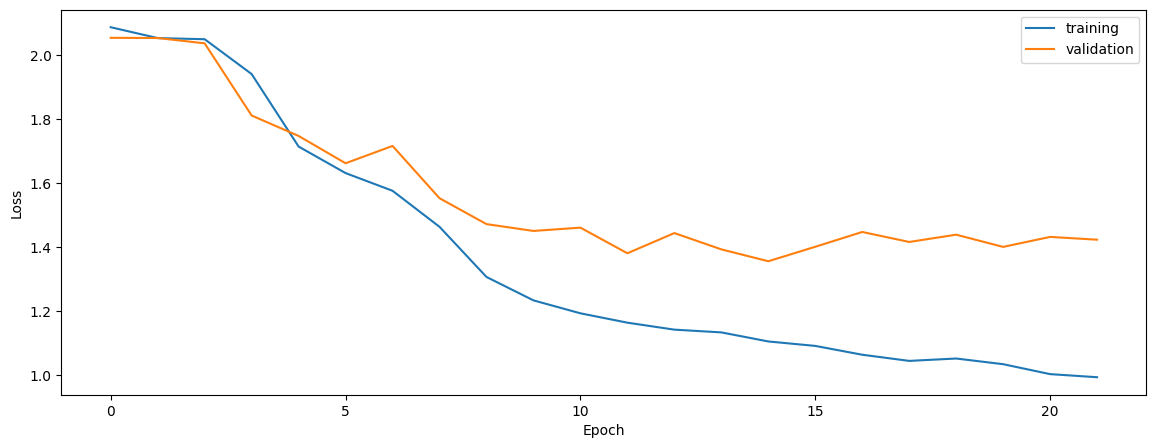

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.5565449810374075


0.47285853398407157


0.5501520347127432


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5084428143382537


0.5035847142374028


0.5195100412114869


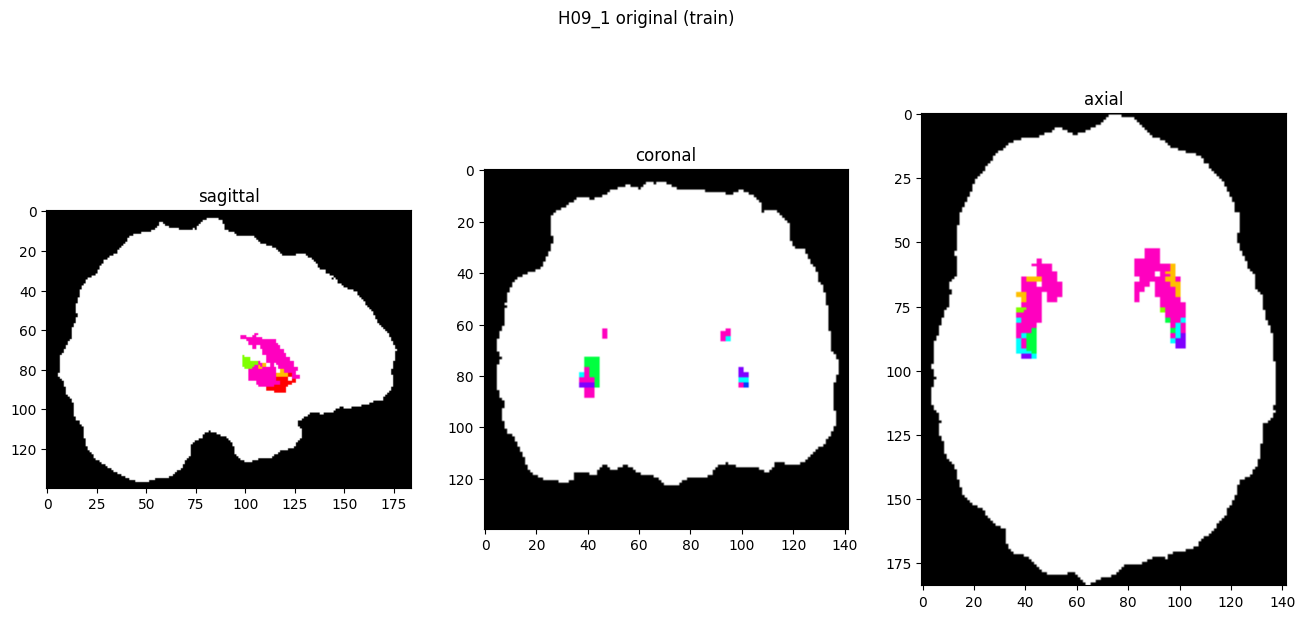

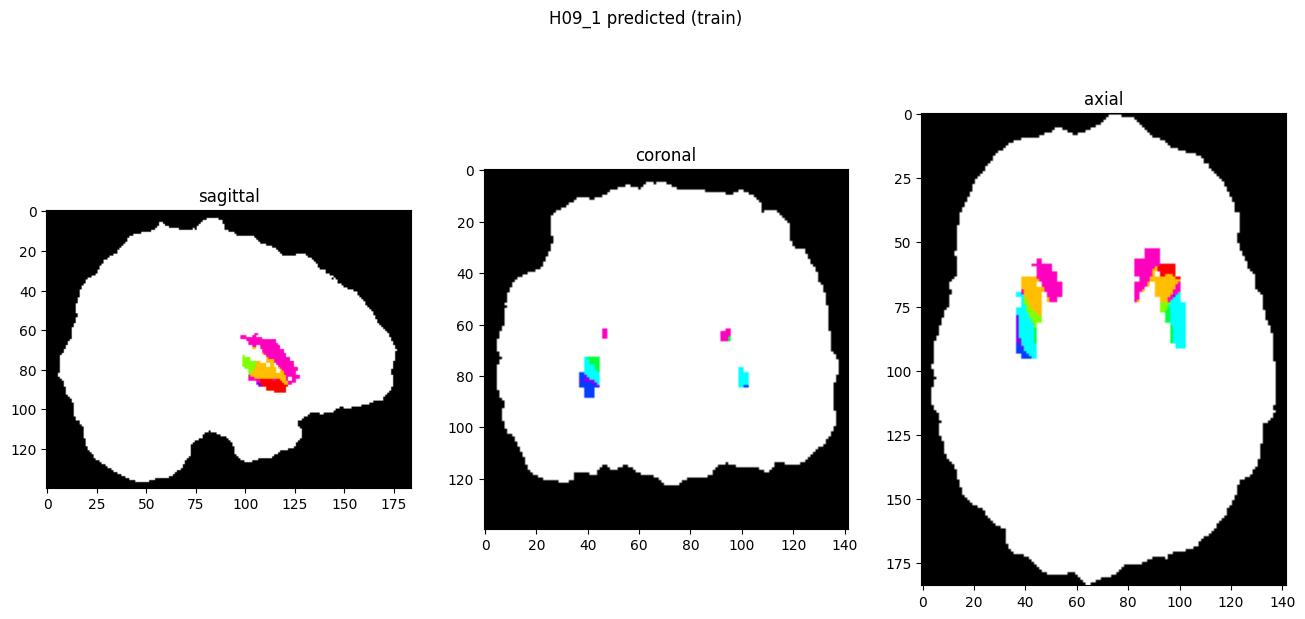

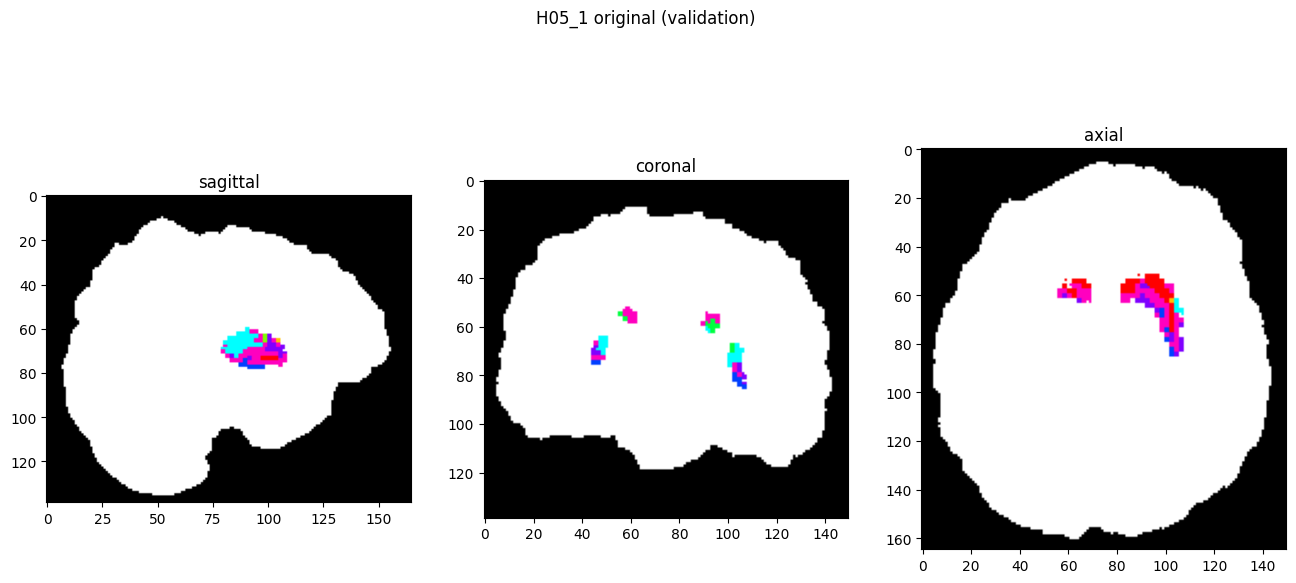

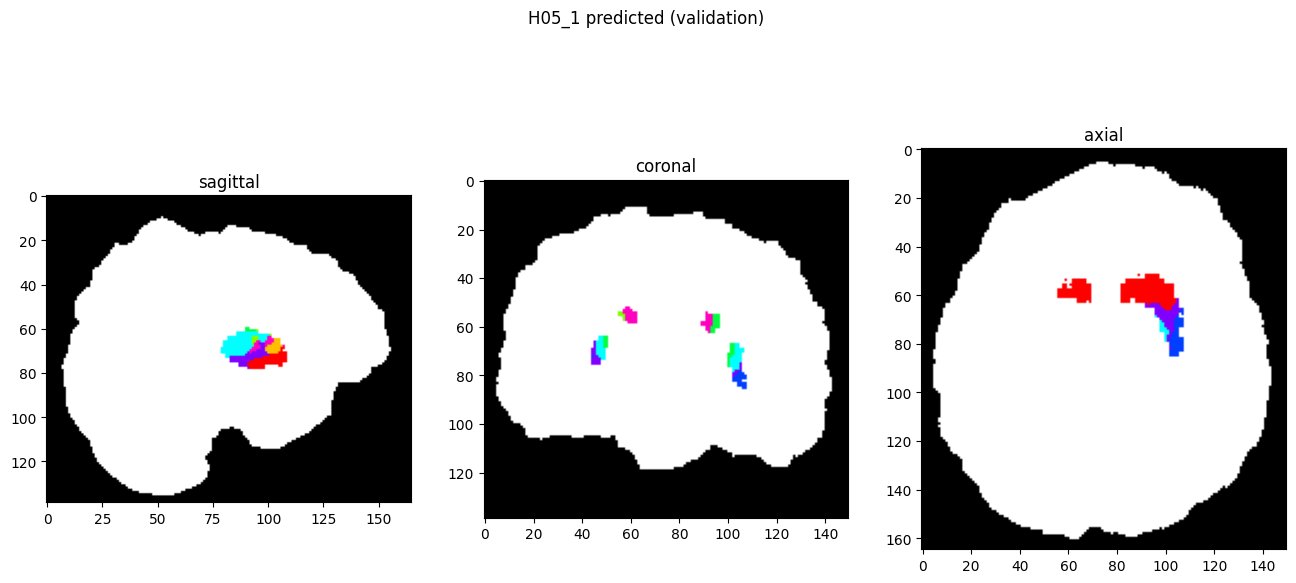

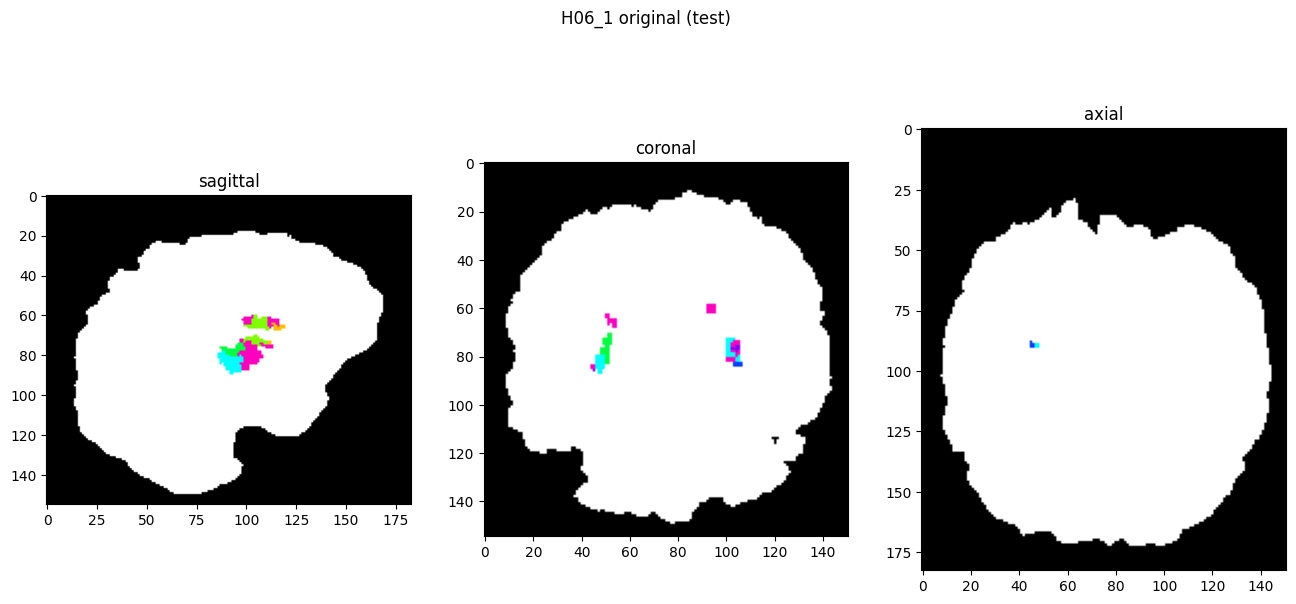

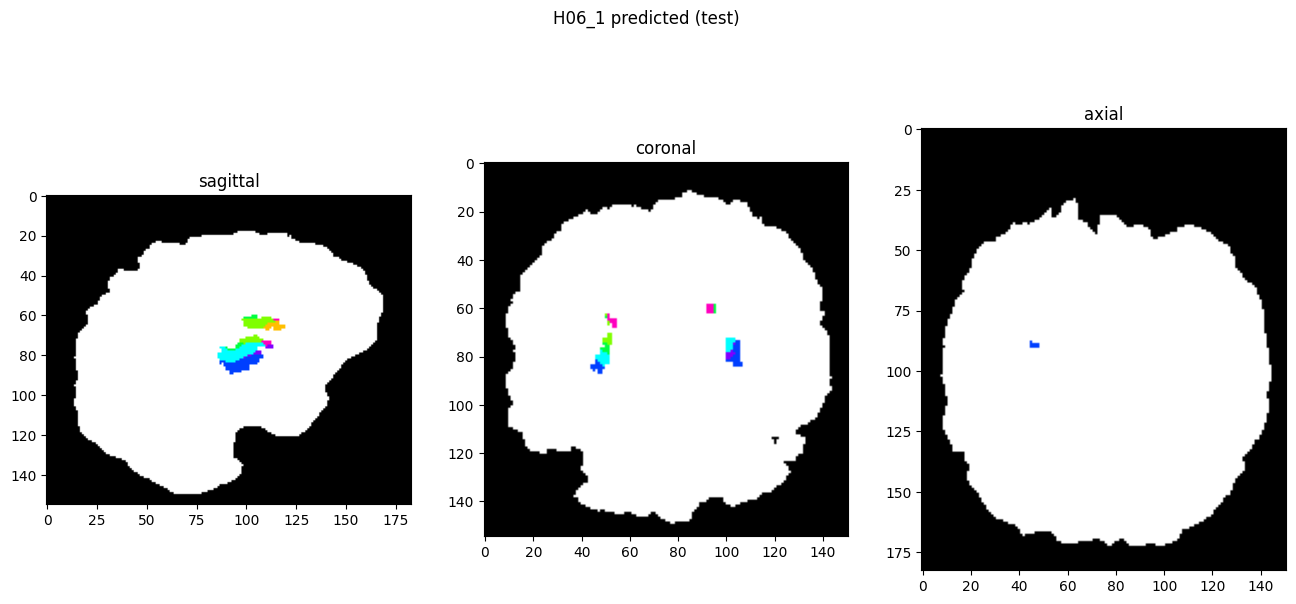

In [9]:
showResults(model, gen, threshold=0)